# Load the data

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
from google.colab import drive
drive.mount('/content/drive')
test_data = np.load("/content/drive/My Drive/5329 Code/test_data.npy")
test_label = np.load("/content/drive/My Drive/5329 Code/test_label.npy").reshape(-1)
train_data = np.load("/content/drive/My Drive/5329 Code/train_data.npy")
train_label = np.load("/content/drive/My Drive/5329 Code/train_label.npy").reshape(-1)
!git clone https://github.com/Iridescent4113/HYXrepo.git
%cd <Notebook 1(5)>

Mounted at /content/drive


FileNotFoundError: ignored

### Activation Function

In [ ]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    def __ReLU(self, x):
        return np.maximum(0, x)
    def __ReLU_deriv(self, x):
        x[x>0]=1
        x[x<=0]=0
        return x

    def __softmax(self,x):
        e=np.exp((x.T-np.max(x,axis=1)).T)
        return (e.T/e.sum(axis=1)).T
    
    def __softmax_deriv(self,x):
        matrix=np.diag(x)
        l=len(matrix)
        for i in range(l):
            for j in range(l):
                matrix[i][j]=x[i]*(1-x[i]) if i==j else -x[i]*x[j]
        return matrix
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv


### Module

#### Hidden layer

In [ ]:
import math
def form(input,out):
    return np.random.uniform(
        low=-np.sqrt(6.0/(input+out)),
        high=np.sqrt(6.0/(input+out)),
        size=(input,out)
    )

def Kform(input,out,m="in"):
    f=input if m=="in" else out
    l=math.sqrt(3.0)*math.sqrt(2.0)/math.sqrt(f)
    w=np.random.uniform(
        low=-l,
        high=l,
        size=(input,out)
    )
    return w
    

In [ ]:
class LinearLayer():

    def __init__(self,n_in,n_out,mode="K"):
        self.input=None
        if mode=="K":
            self.W=Kform(n_in,n_out,m="in")
        else:
            self.W=form(n_in,n_out)
        self.b=np.zeros(n_out,)
        self.grad_W=np.zeros(self.W.shape)
        self.grad_b=np.zeros(self.b.shape)
    
    def forward(self,x):
        lin_output=np.dot(x,self.W)+self.b
        self.output=lin_output
        self.input=x
        return lin_output
    
    def backward(self,delta): 
        self.grad_W=np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b=np.sum(delta,axis=0)
        out=delta.dot(self.W.T)
        return out



#### Cross Entropy Loss

In [ ]:
class cross_entropy_loss():

    def __init__(self):
        self.pred=None
        self.real=None
        self.num=None
        self.delta=None
        self.loss=None
    
    def forward(self,pred,real):
        self.pred=pred
        self.real=real
        self.num=self.real.shape[0]
        l=-np.log(self.pred[range(self.num),self.real]+0.00000000001)
        self.loss=np.sum(l)/self.num
        return self.loss

    def backward(self):
        out=self.pred
        out[range(self.num),self.real]-=1
        self.delta=out
        return out
    

#### Dropout

In [ ]:
class Dropout():
    def __init__(self,dropout):
        self.dropout=dropout
        self.d=None

    def forward(self,x,train=True):
        if train:
            self.d=np.random.binomial(1,1-self.dropout,
                                      size=x.shape
                                      )/(1-self.dropout)
            return x*self.d
        else:
            return x
    
    def backward(self,delta):
        return delta*self.d

#### batch normalization

In [ ]:
class bnlayer():
    def __init__(self,gamma,beta,momentum=0.9,mean=None,var=None):
        self.mu=mean
        self.var=var
        self.m=momentum
        self.c=None
        self.beta=beta
        self.gamma=gamma
        self.bsize=None
        self.std=None
        self.dgamma=None
        self.dbeta=None
        self.n=None
    
    def forward(self,x,train=True):
        if self.mu is None:
            self.mu=np.zeros(x.shape[1])
            self.var=np.zeros(x.shape[1])
        if train:
            mm=x.mean(axis=0)
            self.c=x-mm
            v=np.mean(self.c*self.c,axis=0)
            self.std=np.sqrt(v+0.0000000000001)
            self.n=self.c/self.std
            self.bsize=x.shape[0]
            self.mu=self.m*self.mu+(1-self.m)*mm
            self.var=self.m*self.var+(1-self.m)*v
        else:
            self.c=x-self.mu
            self.n=self.c/(np.sqrt(self.var+0.0000000000001))
        return self.gamma*self.n+self.beta

    def backward(self,delta):
        dbeta=delta.sum(axis=0)
        dgamma=np.sum(self.n*delta,axis=0)
        n=self.gamma*delta
        c=n/self.std
        std=-np.sum((n*self.c)/(self.std**2),axis=0)
        var=0.5*std/self.std
        c+=(2.0/self.bsize)*self.c*var
        mu=np.sum(c,axis=0)
        out=c-mu/self.bsize
        self.dbeta=dbeta.reshape(1,-1)
        self.dgamma=dgamma.reshape(1,-1)
        return out


#### MLP

In [ ]:
class MLP():
    def __init__(self,n_in,n_hide,classes,dropout=0.5,activation='relu'):
        self.droupout=dropout
        self.mode="K" if activation=="relu" else "f"
        # first layer
        self.in_bn=bnlayer(
            gamma=np.ones((1,n_in)),
            beta=np.zeros((1,n_in))
        )
        self.layer1=LinearLayer(n_in,n_hide,self.mode)
        self.batchnorm1=bnlayer(
            gamma=np.ones((1,n_hide)),
            beta=np.zeros((1,n_hide))
        )
        self.dropout1=Dropout(dropout)

        # second layer(hidden layer 1)
        self.layer2=LinearLayer(n_hide,n_hide,self.mode)
        self.batchnorm2=bnlayer(
            gamma=np.ones((1,n_hide)),
            beta=np.zeros((1,n_hide))
        )
        self.dropout2=Dropout(dropout)

        # third (hiddenlayer 2)
        self.layer3=LinearLayer(n_hide,n_hide,self.mode)
        self.batchnorm3=bnlayer(
            gamma=np.ones((1,n_hide)),
            beta=np.zeros((1,n_hide))
        )
        self.dropout3=Dropout(dropout)

        # output layer
        self.layer4=LinearLayer(n_hide,classes,self.mode)
        #activation
        self.softmax=Activation("softmax")
        self.tanh=Activation("tanh")
        self.activation=Activation(activation)
        #loss
        self.loss=cross_entropy_loss()

        self.layer=[self.layer1,self.layer2,self.layer3,self.layer4]
        self.bn=[self.in_bn,self.batchnorm1,self.batchnorm2,self.batchnorm3]

        self.dict=dict()
        self.gd=dict()
        self.seedict()
        
    def forward(self,x,train=True):
        x=self.in_bn.forward(x,train)
        x=self.layer1.forward(x)
        x=self.batchnorm1.forward(x,train)
        x=self.dropout1.forward(x,train)
        x=self.activation.f(x)
        x=self.layer2.forward(x)
        x=self.batchnorm2.forward(x,train)
        x=self.dropout2.forward(x,train)
        x=self.activation.f(x)
        x=self.layer3.forward(x)
        x=self.batchnorm3.forward(x,train)
        x=self.dropout3.forward(x,train)
        x=self.activation.f(x)
        x=self.layer4.forward(x)
        out=self.softmax.f(x)
        return out

    def criterion_crossentropy(self,pred,real):
        loss=self.loss.forward(pred,real)
        delta=self.loss.backward()
        return loss,delta
    
    def backward(self,delta):
        out=self.layer4.backward(delta)
        out=out*self.activation.f_deriv(self.layer4.input)
        out=self.dropout3.backward(out)
        out=self.batchnorm3.backward(out)
        out=self.layer3.backward(out)
        out=out*self.activation.f_deriv(self.layer3.input)
        out=self.dropout2.backward(out)
        out=self.batchnorm2.backward(out)
        out=self.layer2.backward(out)
        out=out*self.activation.f_deriv(self.layer2.input)
        out=self.dropout1.backward(out)
        out=self.batchnorm1.backward(out)
        out=self.layer1.backward(out)
        self.in_bn.backward(out)
        self.seedict()

    def momemtum_sgd(self,x,learningrate,momentum,weightdecay):
        if weightdecay!=0:
            for i in x:
                if "W" in i:
                    self.gd[i]+=self.dict[i]*weightdecay
        for i in x:
            x[i]=momentum*x[i]+learningrate*self.gd[i]
            self.dict[i]-=x[i]
        self.updatedict()
        return x


    def updatedict(self):

        def clipgrad(grad,clip):
            norm=np.linalg.norm(grad)
            if norm>clip:
                grad=grad/norm*clip
            return grad

        for i in range(4):
            clip=4000
            self.layer[i].W=clipgrad(self.dict["layer"+str(i+1)+" W:"+str(i+1)],clip)
            self.layer[i].b=clipgrad(self.dict["layer"+str(i+1)+" b:"+str(i+1)],clip)
            self.bn[i].gamma=clipgrad(self.dict["layer"+str(i+1)+" gamma:"+str(i+1)],clip)
            self.bn[i].beta=clipgrad(self.dict["layer"+str(i+1)+" beta:"+str(i+1)],clip)
    
    def seedict(self):
        for i in range(4):
            self.dict["layer"+str(i+1)+" W:"+str(i+1)]=self.layer[i].W
            self.dict["layer"+str(i+1)+" b:"+str(i+1)]=self.layer[i].b
            self.gd["layer"+str(i+1)+" W:"+str(i+1)]=self.layer[i].grad_W
            self.gd["layer"+str(i+1)+" b:"+str(i+1)]=self.layer[i].grad_b
            self.dict["layer"+str(i+1)+" gamma:"+str(i+1)]=self.bn[i].gamma
            self.dict["layer"+str(i+1)+" beta:"+str(i+1)]=self.bn[i].beta
            self.gd["layer"+str(i+1)+" gamma:"+str(i+1)]=self.bn[i].dgamma
            self.gd["layer"+str(i+1)+" beta:"+str(i+1)]=self.bn[i].dbeta

    def fit(self,X_train,Y_train,X2,Y2,
            learningrate=0.001,
            epoch=5,
            weightdecay=0.01,
            batch_size=24,
            momentum=0.9,
            print1=False,
            steps=100):
        step=math.ceil(X_train.shape[0]/batch_size) 
        step0=epoch*step  
        numval=step0//steps 
        returnepoch=np.zeros(epoch)
        returnminibatch=np.zeros(step0)
        returnsteps=np.zeros(numval)
        accstep=np.zeros(numval)
        v={i:np.zeros_like(j) for i,j in self.dict.items()}

        #train
        total=0
        for i in range(epoch):
            loss=np.zeros(step)
            for it in range(step):
                #mini_batch
                index=random.sample(range(step),step)
                index0=index[it]
                if index0==(step-1):
                    xx=X_train[index0*batch_size:]
                    yy=Y_train[index0*batch_size:]
                else:
                    xx=X_train[batch_size*index0:(batch_size*(index0+1))]
                    yy=Y_train[batch_size*index0:(batch_size*(index0+1))]
                out=self.forward(xx)
                loss[it],delta=self.criterion_crossentropy(out,yy)
                self.backward(delta)
                returnminibatch[total]=loss[it]
                v=self.momemtum_sgd(v,learningrate,momentum,weightdecay)
                total+=1
                if total%steps==0:
                    index1=total//steps-1
                    returnsteps[index1]=np.mean(returnminibatch[(total-steps):total])
                    predict1=self.predict(X2)
                    accstep[index1]=(predict1==Y2).mean()
                    if print1:
                        print("total step:{}|{} loss:{} ,accuracy:{}".format(total,step0,loss[it],accstep[index1]))
            returnepoch[i]=np.mean(loss)
            predict0=self.predict(X2)
            acc=(predict0==Y2).mean()
            if print1:
                print("Epoch{} accuracy {:3f}".format(i+1,acc))
        returndict={
            "epoch loss":returnepoch,
            "step loss":returnsteps,
            "accuracy":accstep,
            "mini batch loss":returnminibatch
        }
        return returndict
    
    def predict(self,x):
        x=np.array(x)
        p=self.forward(x,train=False)
        return np.argmax(p,axis=1).reshape(-1)


In [ ]:
# model=MLP(n_in=128,n_hide=128,classes=10,dropout=0.1)
# nn1 = MLP(n_in = 128, n_hide = 128, classes=10, dropout=0)
# nn1.fit(train_data, train_label, test_data, test_label,
#         learningrate=0.0001,
#         epoch = 10,
#         weightdecay=0,
#         batch_size=10,
#         momentum=1,
#         print1=True,
#         steps=100)
nn3 = MLP(n_in = 128, n_hide = 128, classes=10, dropout=0.1)
nn3.fit(train_data, train_label, test_data, test_label,
        learningrate=0.0001,
        epoch = 10,
        weightdecay=0.01,
        batch_size=10,
        momentum=0.9,
        print1=True,
        steps=100)

total step:100|50000 loss:2.3945580816554157 ,accuracy:0.1194
total step:200|50000 loss:2.6510923701766003 ,accuracy:0.1364
total step:300|50000 loss:2.235776586142844 ,accuracy:0.1522
total step:400|50000 loss:2.5770111302260426 ,accuracy:0.1675
total step:500|50000 loss:2.4169104674025097 ,accuracy:0.1765
total step:600|50000 loss:2.3022926203217113 ,accuracy:0.194
total step:700|50000 loss:2.4032696783932765 ,accuracy:0.1999
total step:800|50000 loss:2.0528852958753365 ,accuracy:0.2117
total step:900|50000 loss:2.352594547278573 ,accuracy:0.2035
total step:1000|50000 loss:1.9379166062287534 ,accuracy:0.2347
total step:1100|50000 loss:2.2220450993989944 ,accuracy:0.2263
total step:1200|50000 loss:2.191303662935253 ,accuracy:0.2415
total step:1300|50000 loss:2.1491047489876873 ,accuracy:0.2494
total step:1400|50000 loss:1.821270419698282 ,accuracy:0.2556
total step:1500|50000 loss:1.9942678803508458 ,accuracy:0.2624
total step:1600|50000 loss:2.340611382082381 ,accuracy:0.2678
total s

{'epoch loss': array([2.07246588, 1.81452408, 1.73680438, 1.67965849, 1.62654833,
        1.59029038, 1.55781612, 1.53456519, 1.49926627, 1.47536541]),
 'step loss': array([2.60783621, 2.52012056, 2.46219672, 2.41349123, 2.38467387,
        2.33345114, 2.277529  , 2.30632321, 2.27541996, 2.25350345,
        2.22510593, 2.22901835, 2.22200652, 2.13546039, 2.0982979 ,
        2.1262959 , 2.13380969, 2.0891839 , 2.10869117, 2.07980162,
        2.03560037, 2.03840108, 2.01481319, 2.0191007 , 1.97485512,
        2.03095515, 2.01948556, 1.95866864, 1.97944226, 2.01059666,
        1.95836468, 1.97983032, 1.95308406, 1.91535098, 1.94660936,
        1.94898843, 1.92130036, 1.86847842, 1.93993236, 1.97069579,
        1.88240841, 1.90630344, 1.91510187, 1.86040209, 1.92320107,
        1.81951339, 1.87493288, 1.89805801, 1.89044282, 1.88615969,
        1.88898852, 1.9299371 , 1.8928448 , 1.83773596, 1.90948485,
        1.89694405, 1.86340253, 1.82965971, 1.8689556 , 1.8472814 ,
        1.85729324,

In [ ]:
# model.fit(train_data,train_label,test_data,test_label,
#           learningrate=0.0001,
#           epoch=200,
#           weightdecay=0.01,
#           batch_size=64,
#           momentum=0.9,
#           print1=True,
#           steps=100)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
val_pred = nn3.predict(test_data)
cm = confusion_matrix(y_true=test_label, y_pred=val_pred)

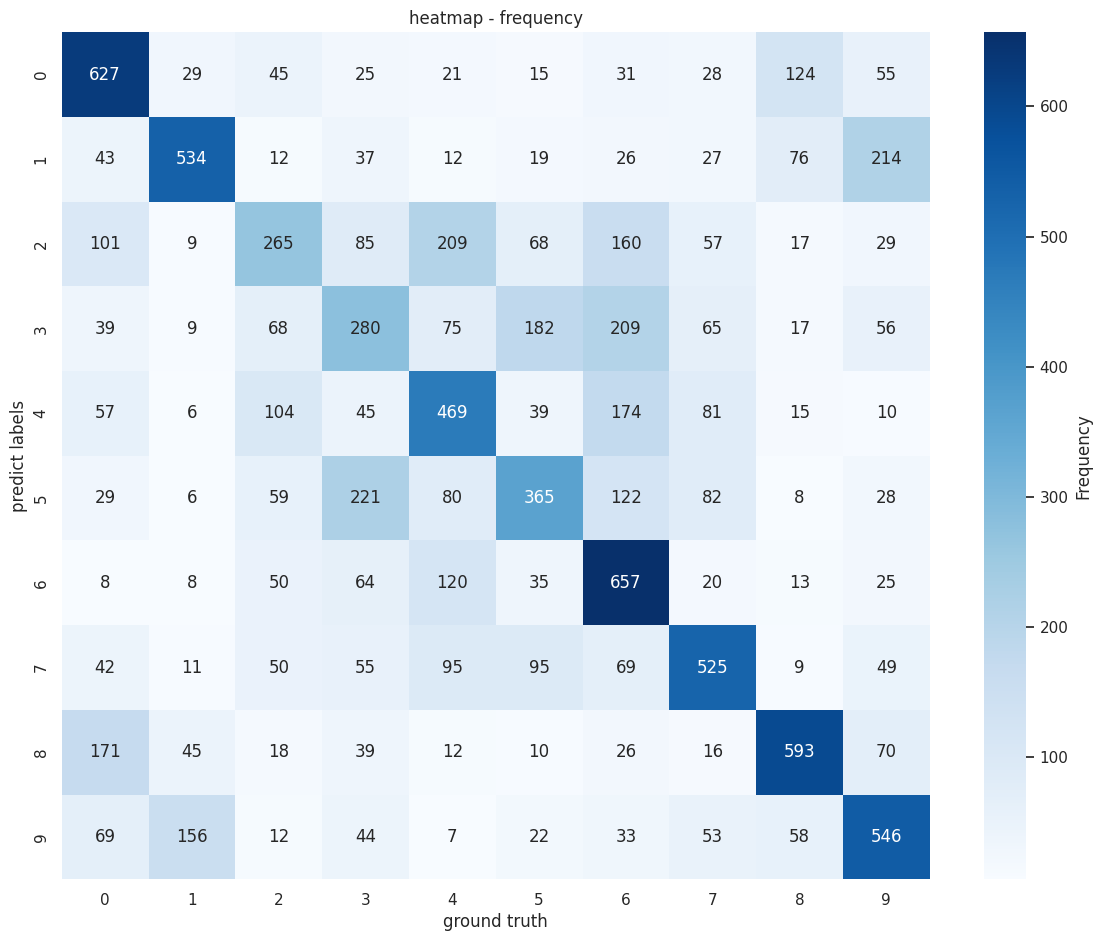

In [ ]:
plt.figure(figsize=(14,11))
sns.set(font_scale=1)
ax = plt.axes()
g = sns.heatmap(cm, annot=True, fmt=',d', cmap='Blues', cbar_kws={'label':'Frequency'}, ax=ax)
g = g.set_ylim([10, 0])
ax.set_title('heatmap - frequency')
ax.set_ylabel('predict labels')
ax.set_xlabel('ground truth')
plt.show()